# 11.7 The Transformer Architecture

We have compared CNNs, RNNs, and self-attention in Section 11.6.2. Notably, self-attention enjoys both parallel computation and the shortest maximum path length. Therefore, it is appealing to design deep architectures by using self-attention. Unlike earlier self-attention models that still rely on RNNs for input representations (Cheng et al., 2016, Lin et al., 2017, Paulus et al., 2017), the Transformer model is solely based on attention mechanisms without any convolutional or recurrent layer (Vaswani et al., 2017).

In [1]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## 11.7.1 Model

As an instance of the encoder–decoder architecture, the overall architecture of the Transformer is presented in Fig. 11.7.1. As we can see, the Transformer is composed of an encoder and a decoder. In contrast to Bahdanau attention for sequence-to-sequence learning in Fig. 11.4.2, the input (source) and output (target) sequence embeddings are added with positional encoding before being fed into the encoder and the decoder that stack modules based on self-attention.

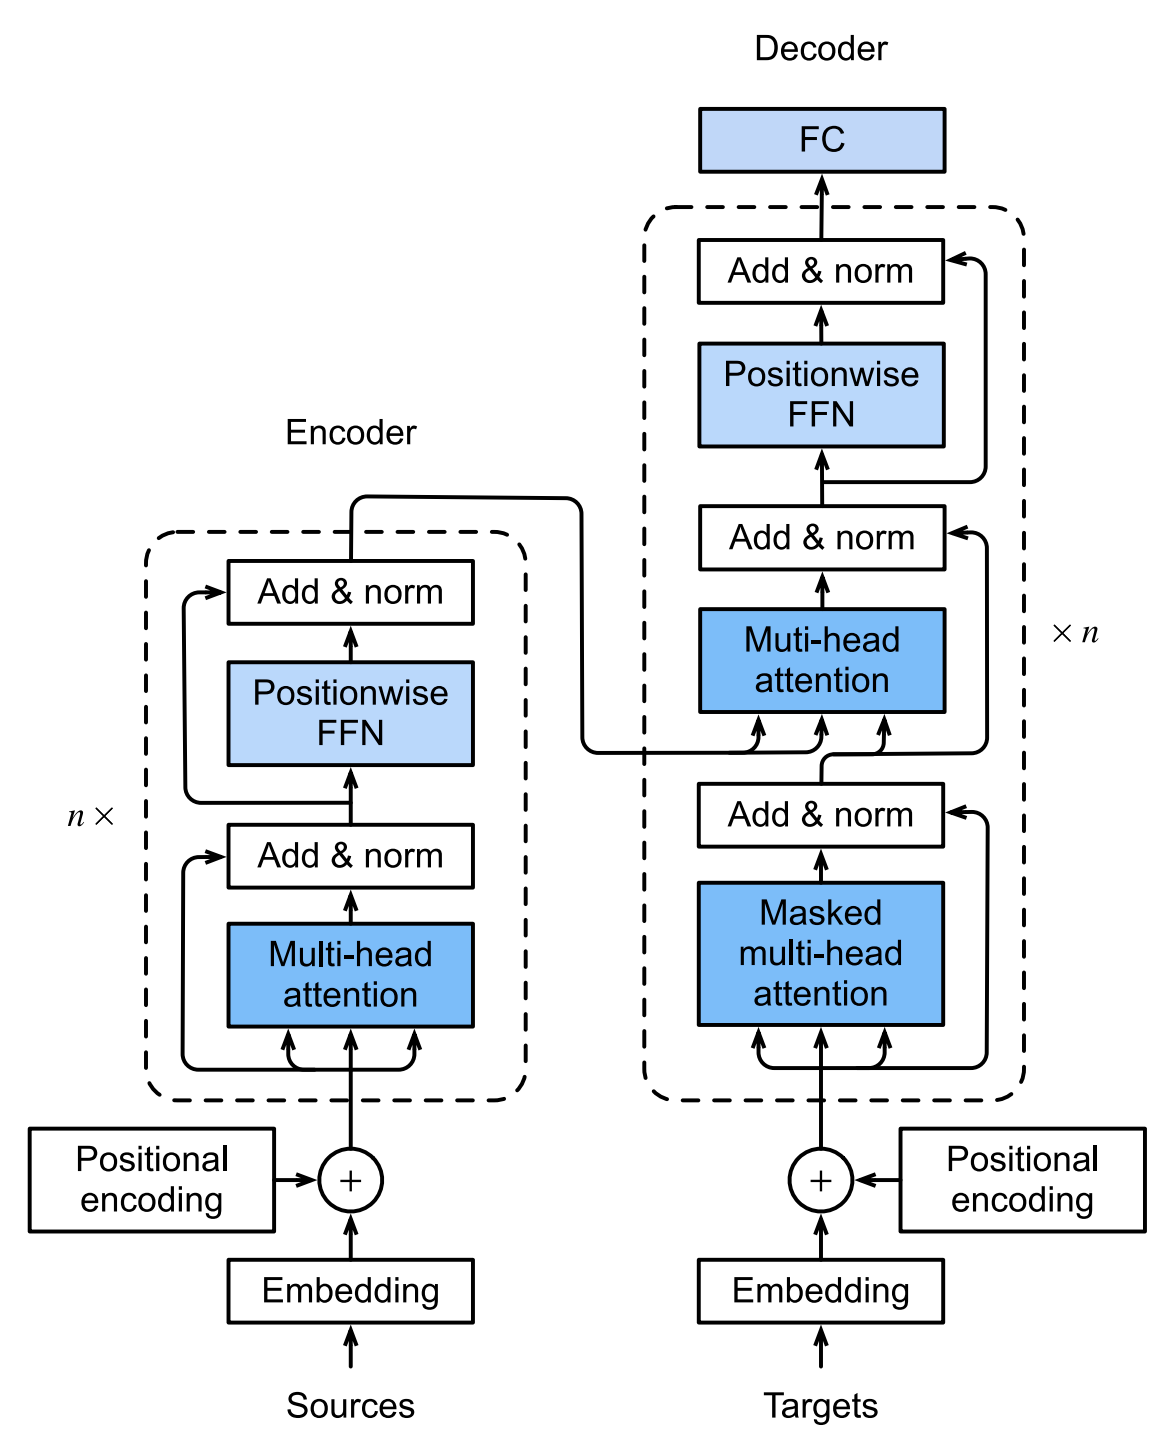


 - Encoder: Transformer encoder is a stack of multiple identical layers, where each layer has two sublayers (either is denoted as sublayer). The first is a multi-head self-attention pooling and the second is a positionwise feed-forward network. Specifically, in the encoder self-attention, queries, keys, and values are all from the outputs of the previous encoder layer. Inspired by the ResNet design of Section 8.6, a residual connection is employed around both sublayers.


 - Decoder: The Transformer decoder is also a stack of multiple identical layers with residual connections and layer normalizations. As well as the two sublayers described in the encoder, the decoder inserts a third sublayer, known as the encoder–decoder attention, between these two. In the encoder–decoder attention, queries are from the outputs of the decoder’s self-attention sublayer, and the keys and values are from the Transformer encoder outputs. In the decoder self-attention, queries, keys, and values are all from the outputs of the previous decoder layer. However, each position in the decoder is allowed only to attend to all positions in the decoder up to that position. This masked attention preserves the autoregressive property, ensuring that the prediction only depends on those output tokens that have been generated.

## 11.7.2 Positionwise Feed-Forward Network

The positionwise feed-forward network transforms the representation at all the sequence positions using the same MLP. This is why we call it positionwise. In the implementation below, the input X with shape (batch size, number of time steps or sequence length in tokens, number of hidden units or feature dimension) will be transformed by a two-layer MLP into an output tensor of shape (batch size, number of time steps, ffn_num_outputs).

In [2]:
class PositionWiseFFN(nn.Module): #@save
    """The positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)
        
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [3]:
ffn = PositionWiseFFN(4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

/home/solee/miniconda3/envs/dive2dl/lib/python3.7/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor([[-0.1451,  0.5996,  0.1008, -0.1067, -0.0706,  0.4821,  0.1823, -0.4338],
        [-0.1451,  0.5996,  0.1008, -0.1067, -0.0706,  0.4821,  0.1823, -0.4338],
        [-0.1451,  0.5996,  0.1008, -0.1067, -0.0706,  0.4821,  0.1823, -0.4338]],
       grad_fn=<SelectBackward0>)

## 11.7.2 Residual Connection and Layer Normalization

In [4]:
ln = nn.LayerNorm(2)
bn = nn.LazyBatchNorm1d()
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# Compute mean and variance from X in the training mode
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [5]:
class AddNorm(nn.Module): #@save
    """The residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [6]:
add_norm = AddNorm(4, 0.5)
shape = (2, 3, 4)
d2l.check_shape(add_norm(torch.ones(shape), torch.ones(shape)), shape)

## 11.7.4 Encoder

In [7]:
class TransformerEncoderBlock(nn.Module): #@save
    
    """The Transformer encoder block."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
    use_bias=False):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
        dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [8]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = TransformerEncoderBlock(24, 48, 8, 0.5)
encoder_blk.eval()
d2l.check_shape(encoder_blk(X, valid_lens), X.shape)

In [9]:
class TransformerEncoder(d2l.Encoder): #@save
    """The Transformer encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
    num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
            num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [10]:
encoder = TransformerEncoder(200, 24, 48, 8, 2, 0.5)
d2l.check_shape(encoder(torch.ones((2, 100), dtype=torch.long), valid_lens),
(2, 100, 24))

## 11.7.5 Decoder

As shown in Fig. 11.7.1, the Transformer decoder is composed of multiple identical layers. Each layer is implemented in the following TransformerDecoderBlock class, which contains three sublayers: decoder self-attention, encoder–decoder attention, and positionwise feed-forward networks. These sublayers employ a residual connection around them followed by layer normalization.

In [16]:
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the Transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads,
        dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads,
        dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
            1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [18]:
decoder_blk = TransformerDecoderBlock(24, 48, 8, 0.5, 0)
X = torch.ones((2, 100, 24))

In [19]:
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
d2l.check_shape(decoder_blk(X, state)[0], X.shape)

In [20]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
            num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)
    
    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
            i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
            i] = blk.attention2.attention.attention_weights
        return self.dense(X), state
    @property
    def attention_weights(self):
        return self._attention_weights

## 11.7.6 Training

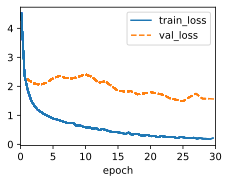

In [21]:
data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
num_blks, dropout)
decoder = TransformerDecoder(
len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
num_blks, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
lr=0.001)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [22]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
        f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


In [23]:
_, dec_attention_weights = model.predict_step(
data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
enc_attention_weights = torch.cat(model.encoder.attention_weights, 0)
shape = (num_blks, num_heads, -1, data.num_steps)
enc_attention_weights = enc_attention_weights.reshape(shape)
d2l.check_shape(enc_attention_weights,
(num_blks, num_heads, data.num_steps, data.num_steps))

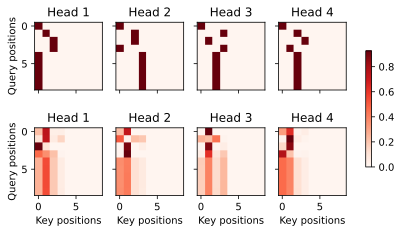

In [24]:
d2l.show_heatmaps(
enc_attention_weights.cpu(), xlabel='Key positions',
ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
figsize=(7, 3.5))